In [1]:
!pip install transformers
!pip install torchtext==0.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.1 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [2]:
from torchtext.data import Field, TabularDataset, BucketIterator,LabelField
import torch

import random
import numpy as np
import matplotlib.pyplot as plt
import time


SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [3]:
print(torch.version.cuda)
print(torch.__version__)
import sys
print(sys.version)

print(np.__version__)


11.8
2.0.1+cu118
3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
1.22.4


In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [5]:

init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)


init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

[CLS] [SEP] [PAD] [UNK]
101 102 0 100
101 102 0 100


In [6]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
print(max_input_length)

512


In [7]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

In [8]:
import pandas as pd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the original dataset
df = pd.read_csv('missom_coded_v1_santosh.csv')
df = df.rename(columns={'label_minority_stress': 'label'})
df = df[['text', 'label']]

empty_cells =  df.isnull().sum()
print(empty_cells)
df.dropna(inplace = True)

empty_cells =  df.isnull().sum()
print(empty_cells)


text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [9]:
# Load the data
def load_data():
  train_data,valid_data, test_data = TabularDataset.splits(
      path= '/content/',
      train='train.csv',
      validation='valid.csv',
      test='test.csv',
      format='csv',
      fields=[('text', TEXT), ('label', LABEL)],
      skip_header=True
  )
  # print('Number of training examples: {}'.format(len(train_data)))
  # print('Number of Validation examples: {}'.format(len(valid_data)))
  # print('Number of testing examples: {}'.format(len(test_data)))
  return train_data,valid_data, test_data

In [10]:
BATCH_SIZE = 4
def create_iterators(train_data, valid_data, test_data):
  train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
      (train_data, valid_data, test_data),
      batch_size = BATCH_SIZE,
      device = device,
      sort_key=lambda x: len(x.text),
      sort_within_batch = True
      )
  return train_iterator, valid_iterator, test_iterator

In [11]:
from transformers import BertTokenizer, BertModel
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
import torch.nn as nn

class BERT_BiGRU(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):

        super().__init__()
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']

        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)

        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]
        _, hidden = self.rnn(embedded)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        output = self.out(hidden)
        return output

In [13]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [15]:
# for name, param in model.named_parameters():
#     if name.startswith('bert'):
#         param.requires_grad = False

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f'The model has {count_parameters(model):,} trainable parameters')

In [17]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [18]:
import torch.optim as optim

def get_model_params(model):
  optimizer = optim.Adam(model.parameters())
  criterion = nn.BCEWithLogitsLoss()
  model = model.to(device)
  criterion = criterion.to(device)

  return model, criterion,optimizer

In [19]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [20]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        predictions = model(batch.text).squeeze(1)

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            predictions = model(batch.text).squeeze(1)

            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
def calc_report(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)
            threshold = 0.5
            output_1 = (predictions > threshold).int()
            y_pred.extend(output_1.tolist())
            y_true.extend(batch.label.tolist())
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            rep = classification_report(y_true, y_pred, labels=[1,0], digits=2, output_dict=True)
    return rep

In [23]:
N_EPOCHS = 10

def run_epoch(N_EPOCHS):
  train_losses = []
  valid_losses = []
  train_accuracies = []
  valid_accuracies = []
  best_valid_loss = float('inf')

  for epoch in range(N_EPOCHS):
      start_time = time.time()
      train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
      valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      train_accuracies.append(train_acc)
      valid_accuracies.append(valid_acc)
      end_time = time.time()
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'tut6-model.pt')
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  return train_losses,valid_losses, train_accuracies,valid_accuracies

In [24]:
from sklearn.model_selection import train_test_split

def save_df_to_cvs(df_train,df_test,df_val):
  # Save the dataframes to CSV files
  df_train.to_csv('train.csv', index=False)
  df_test.to_csv('test.csv', index=False)
  df_val.to_csv('valid.csv', index=False)

def reset_files():
  !rm /content/train.csv
  !rm /content/valid.csv
  !rm /content/test.csv

train_ratio = 0.65
valid_ratio = 0.15
test_ratio = 0.20

In [25]:
##Running Once
classification_report_dict=[]
i = 0
print("experiment running with random_state = ", i, " ...")
X = df # Contains all columns.
y = df[['label']] # Dataframe of just the column on which to stratify.
# Split original dataframe into train and temp dataframes.
df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                      y,
                                                      stratify=y,
                                                      test_size=(1.0 - train_ratio),
                                                      random_state=i)
# Split the temp dataframe into val and test dataframes.
relative_frac_test = test_ratio / (valid_ratio + test_ratio)
df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                  y_temp,
                                                  stratify=y_temp,
                                                  test_size=relative_frac_test,
                                                  random_state=i)
reset_files()
save_df_to_cvs(df_train,df_test,df_val)

TEXT = Field(batch_first = True,
                use_vocab = False,
                tokenize = tokenize_and_cut,
                preprocessing = tokenizer.convert_tokens_to_ids,
                init_token = init_token_idx,
                eos_token = eos_token_idx,
                pad_token = pad_token_idx,
                unk_token = unk_token_idx)

LABEL = LabelField(dtype = torch.float)

train_data,valid_data, test_data = load_data()

LABEL.build_vocab(train_data)


train_iterator, valid_iterator, test_iterator = create_iterators(train_data, valid_data, test_data)

model = BERT_BiGRU(bert,
                        HIDDEN_DIM,
                        OUTPUT_DIM,
                        N_LAYERS,
                        BIDIRECTIONAL,
                        DROPOUT)
model, criterion, optimizer = get_model_params(model)
train_losses,valid_losses, train_accuracies,valid_accuracies = run_epoch(N_EPOCHS)


cal_dict = calc_report(model, test_iterator, criterion)
print(cal_dict)





experiment running with random_state =  0  ...
rm: cannot remove '/content/train.csv': No such file or directory
rm: cannot remove '/content/valid.csv': No such file or directory
rm: cannot remove '/content/test.csv': No such file or directory
Epoch: 01 | Epoch Time: 1m 19s
	Train Loss: 0.461 | Train Acc: 78.80%
	 Val. Loss: 0.409 |  Val. Acc: 80.76%
Epoch: 02 | Epoch Time: 1m 18s
	Train Loss: 0.401 | Train Acc: 81.14%
	 Val. Loss: 0.361 |  Val. Acc: 82.49%
Epoch: 03 | Epoch Time: 1m 19s
	Train Loss: 0.369 | Train Acc: 83.42%
	 Val. Loss: 0.388 |  Val. Acc: 79.61%
Epoch: 04 | Epoch Time: 1m 18s
	Train Loss: 0.338 | Train Acc: 84.72%
	 Val. Loss: 0.395 |  Val. Acc: 82.14%
Epoch: 05 | Epoch Time: 1m 18s
	Train Loss: 0.314 | Train Acc: 86.05%
	 Val. Loss: 0.412 |  Val. Acc: 82.26%
Epoch: 06 | Epoch Time: 1m 18s
	Train Loss: 0.284 | Train Acc: 87.70%
	 Val. Loss: 0.432 |  Val. Acc: 82.14%
Epoch: 07 | Epoch Time: 1m 18s
	Train Loss: 0.230 | Train Acc: 90.06%
	 Val. Loss: 0.380 |  Val. Acc: 

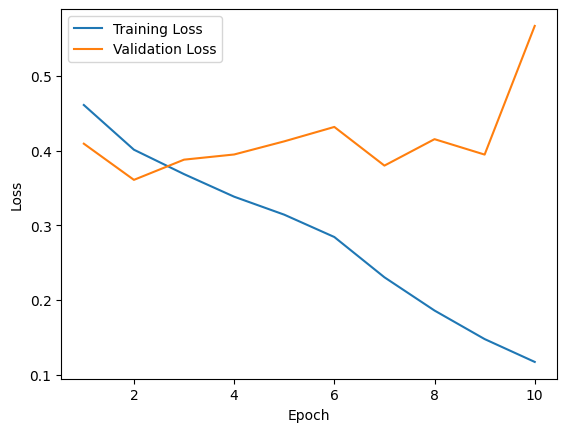

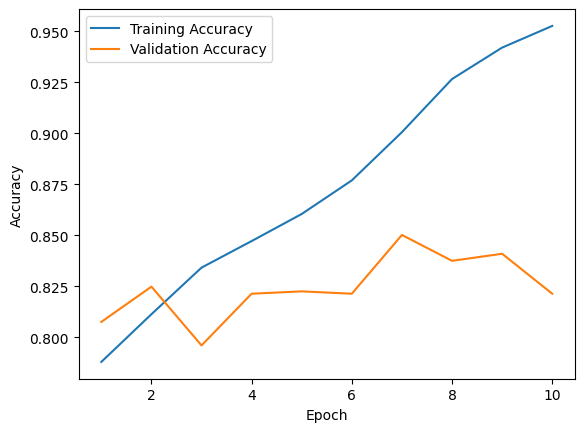

In [26]:
#plot graph of train and valid

epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
#run only once per experiment(5 differeent random_state of train_test_data_split)

classification_report_dict=[]
for i in range(0,5):
  print("experiment running with random_state = ", i, " ...")
  X = df # Contains all columns.
  y = df[['label']] # Dataframe of just the column on which to stratify.
  # Split original dataframe into train and temp dataframes.
  df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                        y,
                                                        stratify=y,
                                                        test_size=(1.0 - train_ratio),
                                                        random_state=i)
  # Split the temp dataframe into val and test dataframes.
  relative_frac_test = test_ratio / (valid_ratio + test_ratio)
  df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                    y_temp,
                                                    stratify=y_temp,
                                                    test_size=relative_frac_test,
                                                    random_state=i)
  reset_files()
  save_df_to_cvs(df_train,df_test,df_val)

  TEXT = Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

  LABEL = LabelField(dtype = torch.float)

  train_data,valid_data, test_data = load_data()

  LABEL.build_vocab(train_data)


  train_iterator, valid_iterator, test_iterator = create_iterators(train_data, valid_data, test_data)

  model = BERT_BiGRU(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)
  model, criterion, optimizer = get_model_params(model)
  run_epoch(N_EPOCHS)

  cal_dict = calc_report(model, test_iterator, criterion)

  classification_report_dict.append(cal_dict)



experiment running with random_state =  0  ...
Epoch: 01 | Epoch Time: 1m 18s
	Train Loss: 0.459 | Train Acc: 79.14%
	 Val. Loss: 0.434 |  Val. Acc: 79.26%
Epoch: 02 | Epoch Time: 1m 18s
	Train Loss: 0.397 | Train Acc: 82.04%
	 Val. Loss: 0.363 |  Val. Acc: 82.37%
Epoch: 03 | Epoch Time: 1m 19s
	Train Loss: 0.370 | Train Acc: 83.69%
	 Val. Loss: 0.407 |  Val. Acc: 79.49%
Epoch: 04 | Epoch Time: 1m 19s
	Train Loss: 0.336 | Train Acc: 84.83%
	 Val. Loss: 0.344 |  Val. Acc: 83.99%
Epoch: 05 | Epoch Time: 1m 19s
	Train Loss: 0.308 | Train Acc: 86.45%
	 Val. Loss: 0.420 |  Val. Acc: 82.14%
Epoch: 06 | Epoch Time: 1m 19s
	Train Loss: 0.273 | Train Acc: 88.66%
	 Val. Loss: 0.390 |  Val. Acc: 83.29%
Epoch: 07 | Epoch Time: 1m 18s
	Train Loss: 0.234 | Train Acc: 90.06%
	 Val. Loss: 0.336 |  Val. Acc: 85.71%
Epoch: 08 | Epoch Time: 1m 18s
	Train Loss: 0.192 | Train Acc: 91.95%
	 Val. Loss: 0.527 |  Val. Acc: 84.45%
Epoch: 09 | Epoch Time: 1m 18s
	Train Loss: 0.149 | Train Acc: 94.21%
	 Val. Loss

In [28]:
def specificCalculation(classification_report_dict):
    Accuracy = []
    precision=[]
    recall=[]
    f1_score=[]
    for i in range(len(classification_report_dict)):
        report=classification_report_dict[i]
        temp=report['accuracy']
        Accuracy.append(temp)

        temp=report['weighted avg']['precision']
        precision.append(temp)

        temp=report['weighted avg']['recall']
        recall.append(temp)

        temp=report['weighted avg']['f1-score']
        f1_score.append(temp)

    print('mean(Accuracy) :',np.mean(Accuracy))
    print('std(Accuracy) :',np.std(Accuracy))
    print('mean np.std(Accuracy) : ',np.round(np.mean(Accuracy),2),"+-",np.round(np.std(Accuracy),2) )
    print('mean np.std(precision) : ', np.round(np.mean(precision),2),"+-",np.round(np.std(precision),2) )
    print('mean np.std(recall) : ', np.round(np.mean(recall),2),"+-",np.round(np.std(recall),2) )
    print('mean np.std(F1-Score) : ', np.round(np.mean(f1_score),2),"+-",np.round(np.std(f1_score),2) )



In [29]:
specificCalculation(classification_report_dict)

mean(Accuracy) : 0.8400345125107851
std(Accuracy) : 0.002866824456572227
mean np.std(Accuracy) :  0.84 +- 0.0
mean np.std(precision) :  0.83 +- 0.0
mean np.std(recall) :  0.84 +- 0.0
mean np.std(F1-Score) :  0.83 +- 0.0


Reference for this code is below to this link.


https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb